# Building a Anime Recommender System

In this project, we will explore two types of recommender systems: 1) collaborative filtering, and 2) content-based filtering. We will build our own recommendation system using the Kaggle dataset in Python.

### Tutorial Outline

This project is broken down into 7 steps:

1. Importing the dependnecies
1. Loading the data
1. Exploratory data analysis 
1. Data pre-processing
1. Collaborative filtering using k-Nearest Neighbors
1. Handling the cold-start problem with content-based filtering 
1. Dimensionality reduction with matrix factorization



### Step 1: Import Dependencies

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load Data

In [140]:
ratings = pd.read_csv('./../data/raw/Col/rating.csv')

In [141]:
anime = pd.read_csv('./../data/raw/Col/anime.csv')

### Step 3: Exploratory Data Analysis

In [142]:
print(anime.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [143]:
print(ratings.isnull().sum())

user_id     0
anime_id    0
rating      0
dtype: int64


In [144]:
#Removing any rows with missing values since the dataset is fairly large
anime.dropna(inplace=True)

In [145]:
n_ratings = len(ratings)
n_animes = ratings['anime_id'].nunique()
n_users = ratings['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique animeId's: {n_animes}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per anime: {round(n_ratings/n_animes, 2)}")

Number of ratings: 7813737
Number of unique animeId's: 11200
Number of unique users: 73515
Average number of ratings per user: 106.29
Average number of ratings per anime: 697.66


### What is the distribution of anime ratings?

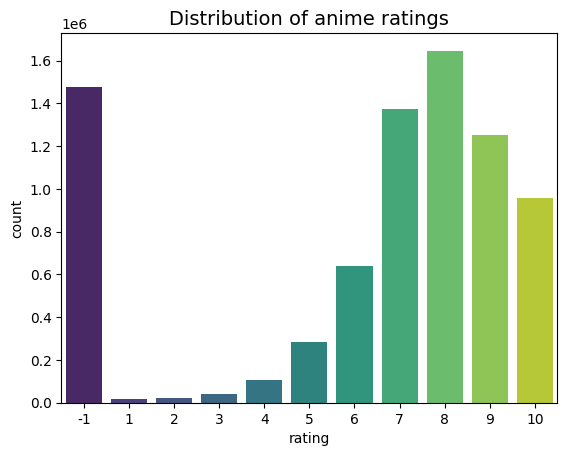

In [146]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of anime ratings", fontsize=14)
plt.show()

In [147]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('user_id')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 6.14.
Mean rating per user: 6.65.


### Which anime are most frequently rated?

In [148]:
anime_ratings = ratings.merge(anime, on='anime_id')
anime_ratings['name'].value_counts()[0:10]

name
Death Note                          39340
Sword Art Online                    30583
Shingeki no Kyojin                  29584
Code Geass: Hangyaku no Lelouch     27718
Elfen Lied                          27506
Angel Beats!                        27183
Naruto                              25925
Fullmetal Alchemist                 25032
Fullmetal Alchemist: Brotherhood    24574
Toradora!                           24283
Name: count, dtype: int64

`Death Note`, `Sword Art Online`, and `Shingeki no Kyojin` have the most ratings.

### What are the lowest and highest rated animes? 

Which anime has the lowest and highest average rating?

In [149]:
mean_ratings = ratings.groupby('anime_id')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
anime[anime['anime_id']==lowest_rated]

,anime_id,name,genre,type,episodes,rating,members
4980,1396,Future GPX Cyber Formula: Early Days Renewal,"Drama, Sci-Fi, Shounen, Sports",OVA,2,6.58,338


`Future GPX Cyber Formula: Early Days Renewal` has the lowest average rating.

In [150]:
highest_rated = mean_ratings['rating'].idxmax()
anime[anime['anime_id'] == highest_rated]

,anime_id,name,genre,type,episodes,rating,members
8364,31211,Choegang Top Plate,"Action, Comedy, Kids, Sports",TV,26,7.2,86


How many ratings does `Choegang Top Plate` have?

In [151]:
ratings[ratings['anime_id']==highest_rated]

,user_id,anime_id,rating
2882192,26895,31211,10


`Choegang Top Plate` may be the "highest" rated anime, but it only has 1 rating. A better approach for evaluating anime popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for anime $i$. In this case, our prior $m$ will be the average mean rating across all animes. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given anime.

In [152]:
anime_stats = ratings.groupby('anime_id')['rating'].agg(['count', 'mean'])
anime_stats.head()

,count,mean
anime_id,,
1,15509,7.558514
5,6927,6.890284
6,11077,6.980590
7,2629,6.040320
8,413,5.113801


In [153]:
C = anime_stats['count'].mean()
m = anime_stats['mean'].mean()

print(f"Average number of ratings for a given anime: {C:.2f}")
print(f"Average rating for a given anime: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given anime: 697.66
Average rating for a given anime: 3.96


Let's test our `bayesian_avg` function out on `Choegang Top Plate`:

In [154]:
choegang = pd.Series([10])
bayesian_avg(choegang)

np.float64(3.965)

`Choegang Top Plate`'s average Bayesian rating is 3.965. 

Let's now apply `bayesian_avg` to all animes in our dataset.

In [155]:
bayesian_avg_ratings = ratings.groupby('anime_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['anime_id', 'bayesian_avg']
anime_stats = anime_stats.merge(bayesian_avg_ratings, on='anime_id')

In [156]:
anime_stats = anime_stats.merge(anime[['anime_id', 'name']])
anime_stats.sort_values('bayesian_avg', ascending=False).head()

,anime_id,count,mean,bayesian_avg,name
5673,9253,19283,8.126796,7.981,Steins;Gate
3965,5114,24574,8.028933,7.917,Fullmetal Alchemist: Brotherhood
3531,4181,17854,7.835275,7.689,Clannad: After Story
2651,2904,24242,7.765943,7.659,Code Geass: Hangyaku no Lelouch R2
6465,11061,8575,7.924082,7.626,Hunter x Hunter (2011)


Using the Bayesian average, we see that `Steins;Gate`, `Fullmetal Alchemist: Brotherhood`, and `Clannad: After Story` are the most highly rated animes. This result makes much more sense since these animes are critically acclaimed films.

In [157]:
anime_stats.sort_values('bayesian_avg', ascending=True).head()

,anime_id,count,mean,bayesian_avg,name
385,413,1131,2.142352,2.834,Hametsu no Mars
8042,19315,2677,3.161375,3.326,Pupa
2929,3287,237,1.725738,3.391,Tenkuu Danzai Skelter+Heaven
7468,16608,231,2.502165,3.595,Shitcom
3856,4866,1397,3.477452,3.637,Pico x CoCo x Chico


With Bayesian averaging, it looks like `Hametsu no Mars`, `Pupa`, and `Tenkuu Danzai Skelter+Heaven` are the worst rated animes.

### A Glimpse at Anime Genres

The animes dataset needs to be cleaned in two ways:

- `genre` is expressed as a string with a comma `,` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.

In [158]:
anime['genre'] = anime['genre'].apply(lambda x: x.split(","))
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic,...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.16,151266


**How many anime genres are there?**

In [159]:
genre_frequency = Counter(g for genres in anime['genre'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 82 genres.


Counter({'Comedy': 3147,
         'Action': 2768,
         ' Sci-Fi': 1955,
         ' Fantasy': 1758,
         ' Shounen': 1635,
         'Adventure': 1445,
         ' Comedy': 1428,
         ' Romance': 1344,
         ' Kids': 1204,
         ' School': 1134,
         ' Slice of Life': 1101,
         ' Drama': 1003,
         ' Supernatural': 987,
         'Drama': 974,
         'Hentai': 940,
         ' Adventure': 871,
         ' Mecha': 814,
         ' Magic': 688,
         ' Historical': 629,
         ' Shoujo': 581,
         ' Ecchi': 564,
         ' Seinen': 522,
         ' Sports': 491,
         'Fantasy': 484,
         ' Super Power': 450,
         ' Music': 450,
         ' Mystery': 414,
         ' Military': 396,
         'Kids': 394,
         'Music': 392,
         ' Parody': 388,
         ' Space': 376,
         ' Horror': 290,
         ' Harem': 272,
         ' Martial Arts': 259,
         'Dementia': 205,
         ' Psychological': 204,
         ' Demons': 203,
         '

In [160]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Comedy', 3147), ('Action', 2768), (' Sci-Fi', 1955), (' Fantasy', 1758), (' Shounen', 1635)]


The top 5 genres are: `Comedy`, `Action`, `Sci-Fi`, `Fantasy` and `Shounen`.

Let's also visualize genres popularity with a barplot.

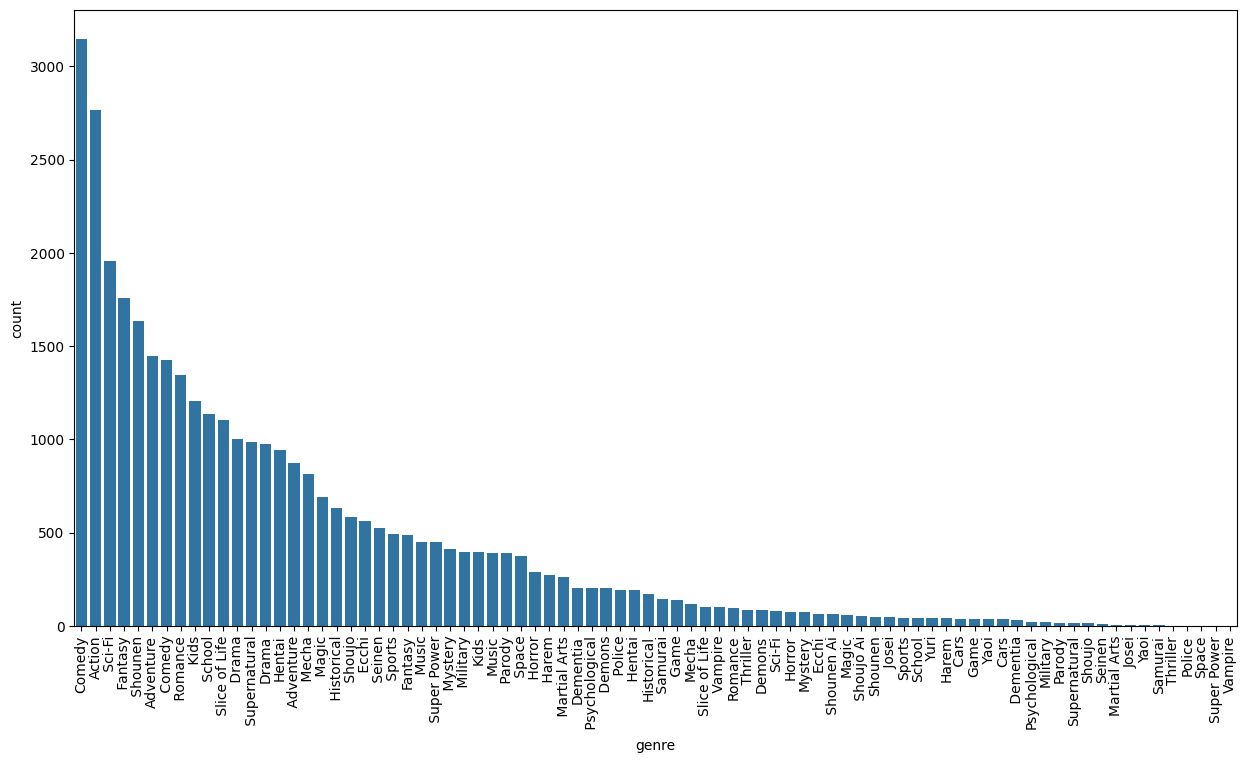

In [161]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

plt.figure(figsize=(15,8))
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent animes. The beauty of collaborative filtering is that it doesn't require any information about the users or the animes user to generate recommendations.

The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **anime_mapper**: maps anime id to anime index
- **user_inv_mapper**: maps user index to user id
- **anime_inv_mapper**: maps anime index to anime id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/anime id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [162]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (user_id, anime_id, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        anime_mapper: dict that maps anime id's to anime indices
        anime_inv_mapper: dict that maps anime indices to anime id's
    """
    M = df['user_id'].nunique()
    N = df['anime_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    anime_mapper = dict(zip(np.unique(df["anime_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    anime_inv_mapper = dict(zip(list(range(N)), np.unique(df["anime_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [anime_mapper[i] for i in df['anime_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper

X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper = create_X(ratings)

In [163]:
X.shape

(73515, 11200)

In [164]:
user_mapper

{np.int64(1): 0,
 np.int64(2): 1,
 np.int64(3): 2,
 np.int64(4): 3,
 np.int64(5): 4,
 np.int64(6): 5,
 np.int64(7): 6,
 np.int64(8): 7,
 np.int64(9): 8,
 np.int64(10): 9,
 np.int64(11): 10,
 np.int64(12): 11,
 np.int64(13): 12,
 np.int64(14): 13,
 np.int64(15): 14,
 np.int64(16): 15,
 np.int64(17): 16,
 np.int64(18): 17,
 np.int64(19): 18,
 np.int64(20): 19,
 np.int64(21): 20,
 np.int64(22): 21,
 np.int64(23): 22,
 np.int64(24): 23,
 np.int64(25): 24,
 np.int64(26): 25,
 np.int64(27): 26,
 np.int64(28): 27,
 np.int64(29): 28,
 np.int64(30): 29,
 np.int64(31): 30,
 np.int64(32): 31,
 np.int64(33): 32,
 np.int64(34): 33,
 np.int64(35): 34,
 np.int64(36): 35,
 np.int64(37): 36,
 np.int64(38): 37,
 np.int64(39): 38,
 np.int64(40): 39,
 np.int64(41): 40,
 np.int64(42): 41,
 np.int64(43): 42,
 np.int64(44): 43,
 np.int64(45): 44,
 np.int64(46): 45,
 np.int64(47): 46,
 np.int64(48): 47,
 np.int64(49): 48,
 np.int64(50): 49,
 np.int64(51): 50,
 np.int64(52): 51,
 np.int64(53): 52,
 np.int64(54

Our `X` matrix contains 610 users and 9724 animes.

### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [165]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.95%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and animes in our matrix that do not have any ratings.

In [166]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

73515

In [167]:
print(f"Most active user rated {n_ratings_per_user.max()} anime(s).")
print(f"Least active user rated {n_ratings_per_user.min()} anime(s).")

Most active user rated 10227 anime(s).
Least active user rated 1 anime(s).


In [168]:
n_ratings_per_anime = X.getnnz(axis=0)
len(n_ratings_per_anime)

11200

In [169]:
print(f"Most rated anime has {n_ratings_per_anime.max()} ratings.")
print(f"Least rated anime has {n_ratings_per_anime.min()} ratings.")

Most rated anime has 39340 ratings.
Least rated anime has 1 ratings.


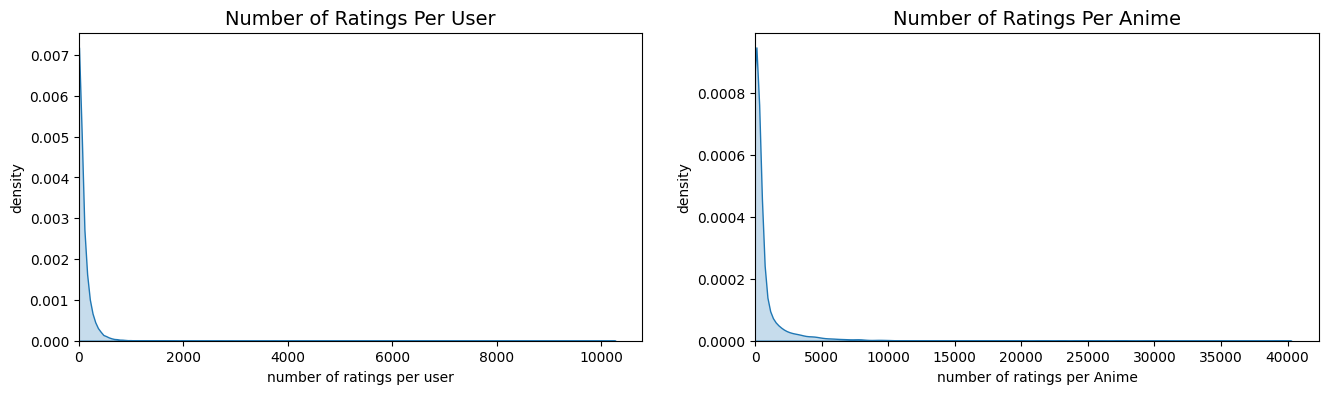

In [170]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_anime, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Anime", fontsize=14)
plt.xlabel("number of ratings per Anime")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ animes that have the most similar user engagement vectors for anime $i$.

In [171]:
def find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given anime id.
    
    Args:
        anime_id: id of the anime of interest
        X: user-item utility matrix
        k: number of similar animes to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar anime ID's
    """
    X = X.T
    neighbour_ids = []
    
    anime_ind = anime_mapper[anime_id]
    anime_vec = X[anime_ind]
    if isinstance(anime_vec, (np.ndarray)):
        anime_vec = anime_vec.reshape(1,-1)
    # use k+1 since kNN output includes the anime_id of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(anime_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(anime_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_animes()` takes in a `animeId` and `X` matrix, and outputs a list of $k$ animes that are similar to the `anime_id` of interest.

Let's see how it works in action. We will first create another mapper that maps anime_id to title so that our results are interpretable.

In [172]:
similar_animes = find_similar_animes(1, X, anime_mapper, anime_inv_mapper, k=10)
similar_animes

[np.int64(5),
 np.int64(205),
 np.int64(6),
 np.int64(227),
 np.int64(30),
 np.int64(2001),
 np.int64(47),
 np.int64(889),
 np.int64(43)]

`find_similar_animes()` returns a list of `animeId`'s that are most similar to your anime of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `anime_id` to `name`.

In [173]:
anime_titles = dict(zip(anime['anime_id'], anime['name']))

anime_id = 1

similar_animes = find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, metric='cosine', k=10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
    print(anime_titles[i])

Because you watched Cowboy Bebop:
Cowboy Bebop: Tengoku no Tobira
Samurai Champloo
Trigun
FLCL
Neon Genesis Evangelion
Tengen Toppa Gurren Lagann
Akira
Black Lagoon
Ghost in the Shell


The results above show the 10 animes that are most similar to Toy Story. Most animes in this list are family animes from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Anime features such as genre are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [174]:
anime_id = 1

similar_animes = find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, metric='euclidean', k=10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
    print(anime_titles[i])

Because you watched Cowboy Bebop:
Cowboy Bebop: Tengoku no Tobira
Trigun
Samurai Champloo
Ghost in the Shell: Stand Alone Complex
Akira
Ghost in the Shell
FLCL
Ghost in the Shell: Stand Alone Complex 2nd GIG
Seihou Bukyou Outlaw Star


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [175]:
n_animes = anime['anime_id'].nunique()
print(f"There are {n_animes} unique anime in our anime dataset.")

There are 12017 unique anime in our anime dataset.


In [176]:
genres = set(g for G in anime['genre'] for g in G)

for g in genres:
    anime[g] = anime.genre.transform(lambda x: int(g in x))
    
anime_genres = anime.drop(columns=['anime_id', 'name','genre', 'type', 'episodes', 'rating', 'members'])

In [177]:
anime_genres.head()

,Comedy,Kids,Sci-Fi,Parody,Space,Supernatural,Parody,Military,Game,Demons,...,Music,Kids,Magic,Dementia,Music,Ecchi,Samurai,Action,Adventure,Harem
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [178]:
cosine_sim = cosine_similarity(anime_genres, anime_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (12017, 12017)


As expected, after passing the `anime_genres` dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape $(n_{\text{animes}}, n_{\text{animes}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between animes along the x and y axes.

### Creating an anime finder function
Let's say we want to get recommendations for animes that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a anime in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which anime we're interested in.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `anime_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [179]:
def anime_finder(title):
    all_titles = anime['name'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Let's test this out with our Jumanji example. 

In [180]:
title = anime_finder('Naruto')
title

'Naruto'

To get relevant recommendations for `Naruto`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a anime index mapper which maps a anime title to the index that it represents in our matrix.

Let's create a anime index dictionary called `anime_idx` where the keys are anime titles and values are anime indices:

In [181]:
anime_idx = dict(zip(anime['name'], list(anime.index)))
idx = anime_idx[title]
print(f"Anime index for Naruto: {idx}")

Anime index for Naruto: 841


Using this handy `anime_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar animes to Jumanji.

In [182]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_animes = [i[0] for i in sim_scores]

`similar_animes` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding anime titles by either creating an inverse anime_idx mapper or using iloc on the title column of the animes dataframe.

In [183]:
print(f"Because you watched {title}:")
anime['name'].iloc[similar_animes]

Because you watched Naruto:


615                                    Naruto: Shippuuden
841                                                Naruto
1103    Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343                                          Naruto x UT
1472          Naruto: Shippuuden Movie 4 - The Lost Tower
1573    Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...
2458                 Naruto Shippuuden: Sunny Side Battle
2997    Naruto Soyokazeden Movie: Naruto to Mashin to ...
175                                Katekyo Hitman Reborn!
7628                              Kyutai Panic Adventure!
Name: name, dtype: object

We can test our recommender further with other anime titles. For your convenience, let's package the steps into a single function which takes in the anime title of interest and number of recommendations.

In [184]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = anime_finder(title_string)
    idx = anime_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_animes = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(anime['name'].iloc[similar_animes])

In [185]:
get_content_based_recommendations('FullMetal', 10)

Because you watched Fullmetal Alchemist: Brotherhood:
200                                  Fullmetal Alchemist
1558       Fullmetal Alchemist: The Sacred Star of Milos
9259                                     Kkomaeosa Ttori
101                           Magi: The Kingdom of Magic
268                         Magi: The Labyrinth of Magic
290                          Magi: Sinbad no Bouken (TV)
461                               Magi: Sinbad no Bouken
795                       Densetsu no Yuusha no Densetsu
879                  Tales of Vesperia: The First Strike
1991    Tsubasa Chronicle: Tori Kago no Kuni no Himegimi
Name: name, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and animes. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent animes which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$

In [186]:
svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(11200, 20)

In [187]:
anime_id = 1
similar_animes = find_similar_animes(anime_id, Q.T, anime_mapper, anime_inv_mapper, metric='cosine', k=10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
    print(anime_titles[i])

Because you watched Cowboy Bebop:
Samurai Champloo
Trigun
Cowboy Bebop: Tengoku no Tobira
FLCL
Akira
Ghost in the Shell: Stand Alone Complex
Ghost in the Shell
Ghost in the Shell: Stand Alone Complex 2nd GIG
Berserk


The results above are the most similar animes to Cowboy Bebop using kNN on our “compressed” anime-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as anime genre.